In [ ]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py

import glob
import os
import time
import sys
from functools import partial

# from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Add
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
import keras.backend as K

import tensorflow as tf

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

import h5py

# from tensorflow.compat.v1.keras.backend import set_session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.compat.v1.Session(config=config)
# graph = tf.compat.v1.get_default_graph()
# set_session(sess)

# import keras.backend.tensorflow_backend as KTF

# KTF.set_session(sess)

In [2]:
def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var)
          for var, grad in zip(var_list, grads)]

class RandomWeightedAverage(Add):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        input1, input2 = inputs
        alpha = K.random_uniform((K.shape(input1)[0], 1, 1, 1))
        return (alpha * input1) + ((1 - alpha) * input2)

class WGANGP():
    def __init__(self, width, height, channels):
        self.img_rows = width
        self.img_cols = height
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(self.latent_dim,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
#         with tf.GradientTape() as tape:
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

#         model.add(UpSampling2D())
#         model.add(Conv2D(16, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))        
        
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size, sample_interval=50):

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in tqdm(range(epochs)):
            print(epoch)
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
#             print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images('wgan_gp', epoch)

    def sample_images(self, folder, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        generatedImage = 0.5 * self.generator.predict(noise) + 0.5
        
        plt.figure(figsize=(10,10))
        
        fig, axs = plt.subplots(r,c)

        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generatedImage[cnt],interpolation='nearest')
                axs[i,j].axis('off')
                cnt+=1
        plt.tight_layout()

        path = 'results/'+folder+'/samples'
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        print('sample')
        fig.savefig(path+'/epoch_%d.png' % epoch)
#         plt.close()


In [3]:
# x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
X = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
# X = np.concatenate([x_train, x_valid])

X.shape

(32768, 64, 64, 3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 128)      

  0%|          | 0/11 [00:00<?, ?it/s]

0


  9%|▉         | 1/11 [00:28<04:40, 28.04s/it]

sample
1


FailedPreconditionError:  Error while reading resource variable _AnonymousVar65 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar65/N10tensorflow3VarE does not exist.
	 [[node mul_33/ReadVariableOp (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_17990]

Function call stack:
keras_scratch_graph


<Figure size 720x720 with 0 Axes>

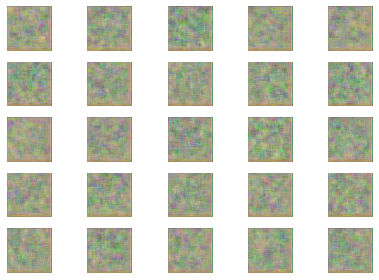

In [4]:
wgan = WGANGP(64, 64, 3)
wgan.train(X, epochs=11, batch_size=128, sample_interval=10)

### Generating images with pre-trained actor ###
Images from level 3 dataset

In [ ]:
t ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(cosaved_actor = load_model('models/actor_final.h5')

In [ ]:
noise = np.random.normal(0,1,size=(1,100))
imgs = saved_actor.predict(noise)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow((imgs[0]*1* 127.5+127.5).astype(np.int32))

Images from PCam dataset

### Helper methods ###

In [2]:
def init_folders(name):
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.exists('results/'+name):
        os.mkdir('results/'+name)
        
def save_loss(name, epoch, Dloss, Gloss):
    path = 'results/'+name+'/loss'
    if not os.path.exists(path):
        os.mkdir(path)
    plt.figure(figsize=(10,8))
    plt.plot(Dloss,label='Dsicriminiative loss')
    plt.plot(Gloss,label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path+'/loss_%d.png' % epoch)
    
def save_samples(folder, w, h, c, epoch, G,example=16, dim=(10,10),figsize=(10,10), randomDim=100):
    noise = np.random.normal(0,1,size=(example,randomDim))
    generatedImage = G.predict(noise)
    
    plt.figure(figsize=figsize)
    
    for i in range(example):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow((generatedImage[i]* 127.5+127.5).astype(np.int32),interpolation='nearest',cmap='gray')
        '''drop the x and y axis'''
        plt.axis('off')
    plt.tight_layout()
    
    path = 'results/'+folder+'/samples'
    if not os.path.exists(path):
        os.mkdir(path)
    plt.savefig(path+'/epoch_%d.png' % epoch)
    
def save_models(name, epoch, d=None, g=None):
    path = 'results/'+name+'/models'
    if not os.path.exists(path):
        os.mkdir(path)
    g.save(path+'/G_%d.h5' % epoch)
    d.save(path+'/D_%d.h5' % epoch)
    
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes


# class CustomDataProvider:
#     def __init__(self, batch_size):
#         self.batch_size = batch_size
#         self.file = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')
#         self.dataset = self.file['x']
#         self.input_shape = self.dataset[0].shape
#         self.image_number = self.dataset.shape[0]
        
#     def sample(self):
#         random_index = np.random.randint(0, self.image_number - self.batch_size)
#         return (self.dataset[random_index : random_index +  self.batch_size] - 127.5) / 127.5
        
#     def close(self):
#         if self.file:
#             self.file.close()
#         self.file = None
        
#     def __del__(self):
#         self.close()

class PcamDataProvider:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.file = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')
        self.dataset = self.file['x']
        self.input_shape = self.dataset[0].shape
        self.image_number = self.dataset.shape[0]
        
    def sample(self):
        random_index = np.random.randint(0, self.image_number - self.batch_size)
        return (self.dataset[random_index : random_index +  self.batch_size] - 127.5) / 127.5
        
    def close(self):
        if self.file:
            self.file.close()
        self.file = None
        
    def __del__(self):
        self.close()

### Wasserstein loss ###

In [3]:
def wasserstein_loss(y_true,y_pred):
    return K.mean(y_true*y_pred)

### Final critic

In [4]:
def create_critic_final(width, height, channels, kernel_size=3):
    """ Declare discriminator """

    model = Sequential()

    model.add(Conv2D(32, kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2), 
                     kernel_size=kernel_size, strides=2, 
                     input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same",
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same",
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(256,
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Dense(1,
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))

    return model

### Final actor ###

In [5]:
def create_actor_final(width, height, channels, latent_dim=100):
    
    model = Sequential()

    model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim,
                    kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    model.add(Reshape((int(width/4),int(height/4), 32)))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
 
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    
    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))
    
    return model

### Training method ###

In [11]:
def train(name, critic, actor, data,
          batch_size=64,
          epochs=3000, 
          randomDim=100, 
          do_save_loss=True, 
          do_save_models=True, 
          do_save_samples=True, 
          batchCount=128, 
          epoch_offset=0):
    """
    :name: name of the directory, which will store all data
    :critic: model for critic
    :actor: model for critic
    """
    
    init_folders(name)

    batchsize = batch_size

    width, height, channels = sampler.input_shape

    critic.compile(loss=wasserstein_loss,optimizer=RMSprop(lr=0.00005))
    generator = actor
    discriminator = critic

    discriminator.trainable = False
    gan_input = Input((randomDim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(gan_input,gan_output)
    gan.compile(loss=wasserstein_loss,optimizer=RMSprop(lr=0.00005))

    Dloss = []
    Gloss = []

#     print('Actor', get_model_memory_usage(batchsize, generator), 'GB')
#     print('Critic', get_model_memory_usage(batchsize*2, discriminator), 'GB')
    
#     print('Epochs',epochs)
#     print('Bathc size',batchsize)
#     print('Batches per epoch',batchCount)

    for e in range(epoch_offset+1,epochs+1):
        for _ in tqdm(range(batchCount), desc="epoch "+str(e)):
            imageBatch = sampler.sample()
            
            #Get a random set of input noise and images
            noise = np.random.normal(0,1,size=[batchsize,randomDim])
            generatedImages = generator.predict(noise)
            
            X = np.concatenate([imageBatch,generatedImages])
            
            yDis = np.ones(2*batchsize)
            
            yDis[:batchsize] = -1
            
            #Train critic
            discriminator.trainable = True
            
            ### Clip weights ###
            weights = [np.clip(w, -0.01, 0.01) for w in discriminator.get_weights()]
            discriminator.set_weights(weights)
            
            dloss = discriminator.train_on_batch(X,yDis)
            
            #Train actor
            noise = np.random.normal(0,1,size=[batchsize,randomDim])
            yGen = np.ones(batchsize) * -1
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise,yGen)

        if e ==1 or e % 5 == 0:            
            noise = np.random.normal(0, 1, (1, randomDim))
            gen_imgs = (generator.predict(noise)* 127.5 + 127.5).astype(np.int)
            plt.figure()
            plt.imshow(gen_imgs[0])

    plt.figure(figsize=(15,6))
    plt.plot(np.array(Gloss), label='G')
    plt.plot(np.array(Dloss), label='D')
    plt.legend()

                

### Start training ###

(294912, 64, 64, 3)

In [12]:
# critic = load_model('results/WGAN_multi_gpu_critic1/models/D_170.h5', custom_objects={'wasserstein_loss': wasserstein_loss})
# actor = load_model('results/WGAN_multi_gpu_critic1/models/G_170.h5', custom_objects={'wasserstein_loss': wasserstein_loss})
critic = create_critic_final(96, 96, 3)
actor = create_actor_final(96, 96, 3, latent_dim=100)

epoch 100: 100%|██████████| 128/128 [00:32<00:00,  3.98it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


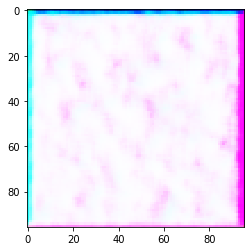

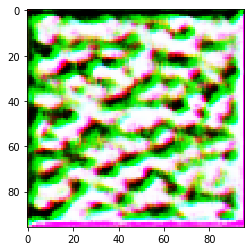

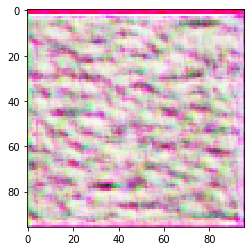

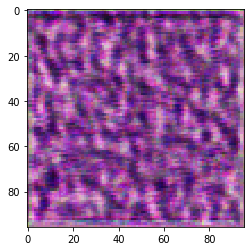

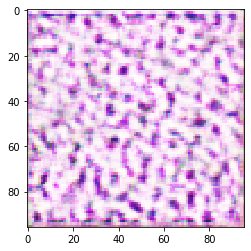

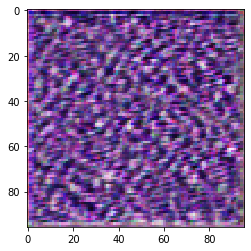

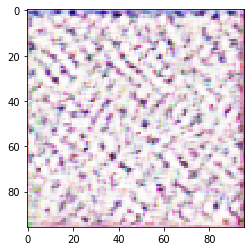

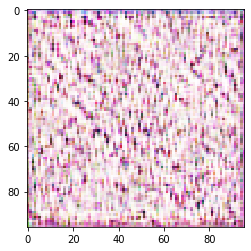

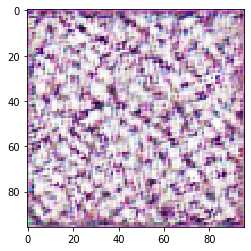

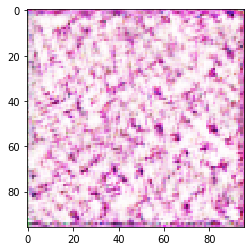

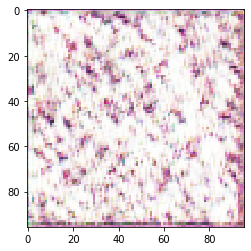

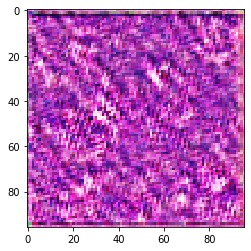

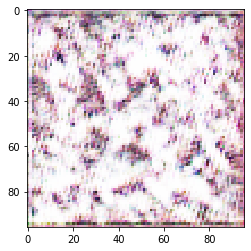

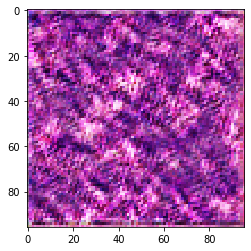

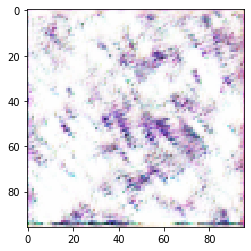

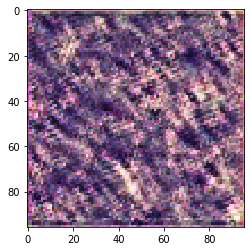

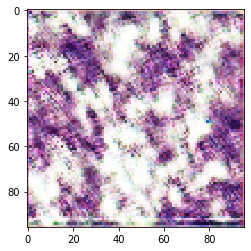

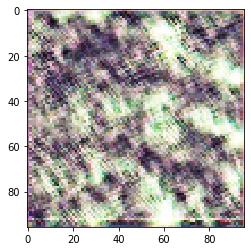

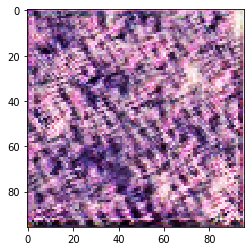

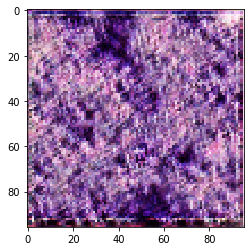

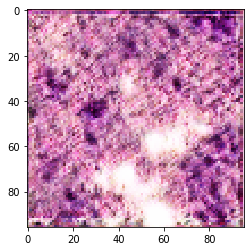

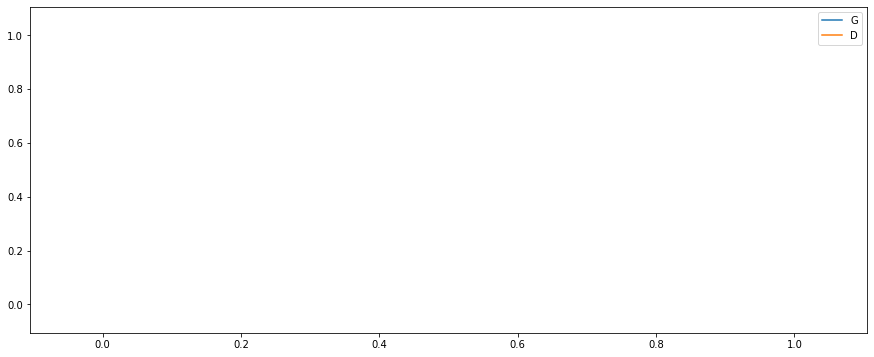

In [13]:
train('WGAN', critic, actor, X, batch_size=64, epochs=100, randomDim=100)